In [1]:
from scipy.io.wavfile import write, read
from scipy import signal
from scipy.fftpack import fft, ifft, fftshift, fftfreq
from scipy.io.wavfile import write, read
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd

import utilFunctions as UF

In [2]:
# leitura do sinal da gaita

fs, gaita_in = read('../gaita.wav')
print(gaita_in.dtype)

# Normalizando amplitude para valores entre -1 e 1 no tipo float 32bits
gaita_in = np.float32(gaita_in)/(2**15 - 1)

# Array de tempo
amostras = np.arange(len(gaita_in))
t = amostras / fs

int16


In [3]:
# Audio de entrada

sd.play(gaita_in)

In [4]:
# Obtendo a envoltória com filtro passa baixa

gaita_abs = abs(gaita_in)

fc = 30                #freq de corte
Wn = fc / (fs / 2)     #freq de corte normalizada

# Utilizando filtro butterworth de terceira ordem para aplicar um passa-baixa no sinal
b, a = signal.butter(3, Wn)
env_filt = signal.filtfilt(b, a, gaita_abs)

# Suprimir ruído desconsiderando amplitudes pequenas
for i in range (env_filt.size):
    if env_filt[i] < 0.005: env_filt[i] = 0

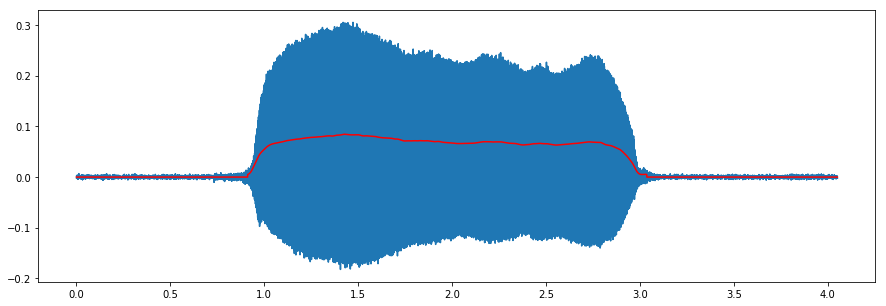

In [5]:
# Plot envoltória com filtro

plt.figure(figsize=(15,5))
plt.plot(t, gaita_in)
plt.plot(t, env_filt, 'r')

plt.show()

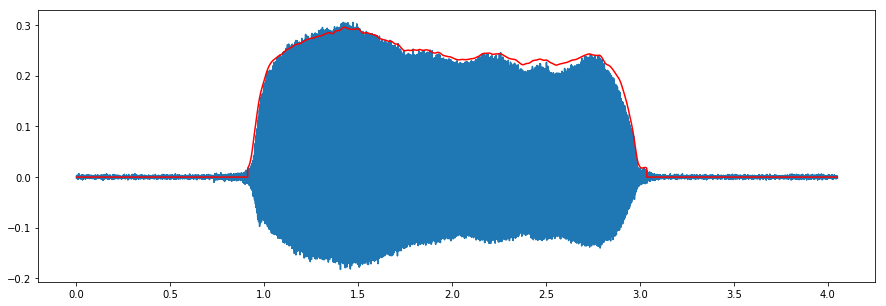

In [6]:
# Multiplicando a envoltória encontrada por uma constante para se aproximar da envoltória do sinal original

plt.figure(figsize=(15,5))

env_filt_ganho = 3.5 * env_filt
plt.plot(t, gaita_in)
plt.plot(t, env_filt_ganho, 'r')

plt.show()

In [7]:
# Aplicando FFT no sinal da gaita

gaita_fft = fft(gaita_in)

# Definindo eixo das frequencias
# Está variando de 0 a fs/2 e pegando só metade do comprimento da fft, ou seja, só a porção positiva

gaita_freqs = np.linspace(0.0, fs/2, gaita_fft.size//2)

# Acertando a amplitude da fft
# Os valores absolutos da FFT dividido pela metade da frequencia de amostragem

amp_gaita_fft = abs(gaita_fft[:int(gaita_fft.size/2)]) / (fs/2)

# Obtendo o angulo da FFT
fase_gaita_fft = np.angle(gaita_fft[:int(gaita_fft.size/2)])

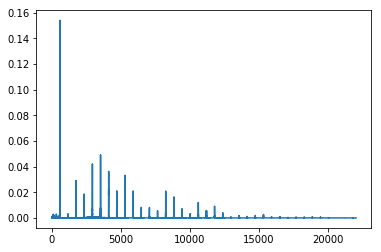

In [8]:
#Plot FFT domínio da frequência

plt.plot(gaita_freqs, amp_gaita_fft)
plt.show()

In [9]:
# Encontrando as frequências e amplitude relativa

pico_loc = []

for i in range (1, amp_gaita_fft.size):
    if amp_gaita_fft[i-1] < amp_gaita_fft[i] and amp_gaita_fft[i] > amp_gaita_fft[i + 1]:
        if amp_gaita_fft[i] > 0.015:
            pico_loc.append(i)

In [10]:
# Encontrando as frequências e amplitude relativa
pico_loc = []
gaita_fft_copy = amp_gaita_fft.copy()

# Laço para identificar a localização dos picos das ffts, desconsiderando os valores próximos
# Limiar para amplitude de 0.015
while True:
    pico = np.amax(gaita_fft_copy)
    loc, = np.where(gaita_fft_copy == pico)
    pico_loc.append(int(loc))
    gaita_fft_copy[int(loc-10):int(loc+10)] = 0
    if pico < 0.015: break

In [12]:
# Somando os senos mais significativos para formar o timbre

timbre = 0
timbre_fase = 0

for loc in pico_loc:
    timbre += (amp_gaita_fft[loc] * np.cos(2 * np.pi * gaita_freqs[loc] * t))
    timbre_fase += (amp_gaita_fft[loc] * np.cos(2 * np.pi * gaita_freqs[loc] * t + fase_gaita_fft[loc]))

In [13]:
gaita_freqs[pico_loc]

array([ 590.10275008, 3541.11010376, 2951.00735368, 4131.45965549,
       5310.92475068, 1770.55505188, 4722.05600886, 5902.50831067,
       8263.41291427, 2360.90460361, 8853.51566435, 8260.45129445])

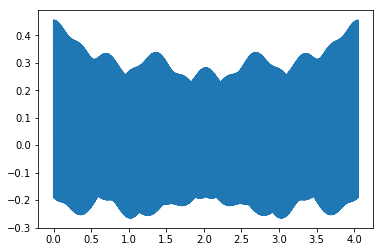

In [14]:
%matplotlib inline
plt.plot(t,timbre)
plt.show()

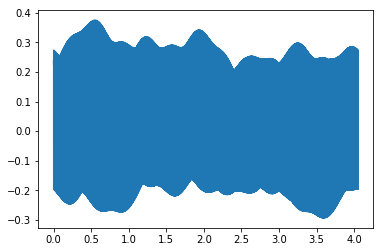

In [16]:
%matplotlib inline
plt.plot(t,timbre_fase)
plt.show()

In [17]:
sd.play(timbre)

In [18]:
gaita_out = timbre * env_filt_ganho
gaita_out3 = timbre_fase * env_filt_ganho

In [19]:
sd.play(gaita_out)

In [20]:
sd.play(gaita_out3)

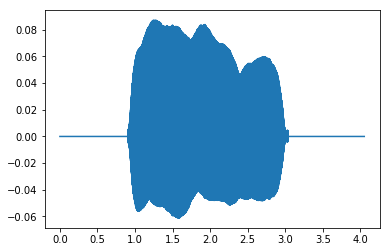

In [21]:
plt.plot(t,gaita_out3)
plt.show()

In [58]:
UF.wavwrite(gaita_out, fs, '../gaita_emu.wav')